From David Asboth's blog post about Self Organising Map


# Take 3D colour vectors and map them onto a 2D surface in such a way that similar colours will end up in the same area of the 2D surface

In [40]:
#Creating dataset of 100
# 3D vector representing R, G and B values
import numpy as np
raw_data = np.random.randint(0, 255, (3, 100))

In [41]:
raw_data

array([[ 70, 208,  50, 118,  92,  30, 230,  41, 164, 193,  45, 249, 187,
        254, 150,  68, 106, 218,  63,  60,  51, 211,  42,  10,  36,  80,
        144, 168, 100, 135,   1, 188,  71, 220,  45, 160, 254, 119, 172,
         37,  73, 189, 208,  39, 102, 195, 114, 145, 148, 220, 215,  77,
        243, 198,  25,  54,  22, 164, 150, 229, 113, 173, 235, 225, 112,
        147,  21, 157,  40, 227, 204,  48, 130,  58,  13, 248,  29,  64,
         61, 101, 134, 180, 252, 117,   8, 215,  37, 153,  26, 211, 137,
        233, 191, 130, 128, 221,  49,  53,  94,  29],
       [176, 122, 181, 174, 216,   1, 211, 195,  51,  43,  56, 107,  92,
        148,  76, 113, 250, 149, 138, 165, 247, 122,  18, 236, 189, 177,
        123, 200, 161, 203,  96,  90, 120,  45, 215, 188, 154, 139, 119,
        195, 240, 175, 189,  64, 117,   4, 160, 127,  35, 244,  37, 155,
         13, 206,  76, 133, 198,  51, 155, 241,  95, 163, 109,  40, 201,
        103, 213, 137, 111, 134, 231, 215, 235,  22, 136,  47,   9,  8

In [42]:
#Setting up SOM
network_dimensions = np.array([5, 5])
n_iterations = 2500
init_learning_rate = 0.01
# establish size variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

# weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

In [43]:
normalise_data = True

# if True, assume all data is on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

# we want to keep a copy of the raw data for later
data = raw_data

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

In [44]:
# select a training example at random
t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))

In [45]:
t

array([[0],
       [0],
       [0]])

In [46]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [47]:
# find its Best Matching Unit
bmu, bmu_idx = find_bmu(t, net, m)

In [48]:
bmu, bmu_idx

(array([[0.11834974],
        [0.06901111],
        [0.07490703]]), array([3, 1]))

In [49]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [50]:

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [51]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [59]:


for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)

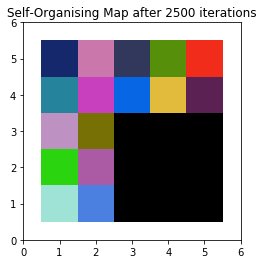

In [60]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()